Question 1: As an AI engineer, you are undoubtedly aware of the concepts of weak AI and strong AI. Could you elaborate on their distinct characteristics, practical applications, and the inherent challenges in transitioning from developing systems based on weak AI to those that are rooted in strong AI? Could you also share your thoughts on the ethical implications and potential societal impacts that might arise from the widespread implementation of strong AI?
Recording for 15 seconds. Please answer the question...
Recording completed and saved as recorded_response_1.wav.


/home/rushabh/Desktop/Aspireit/aspireit-backend/myenv/lib/python3.8/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


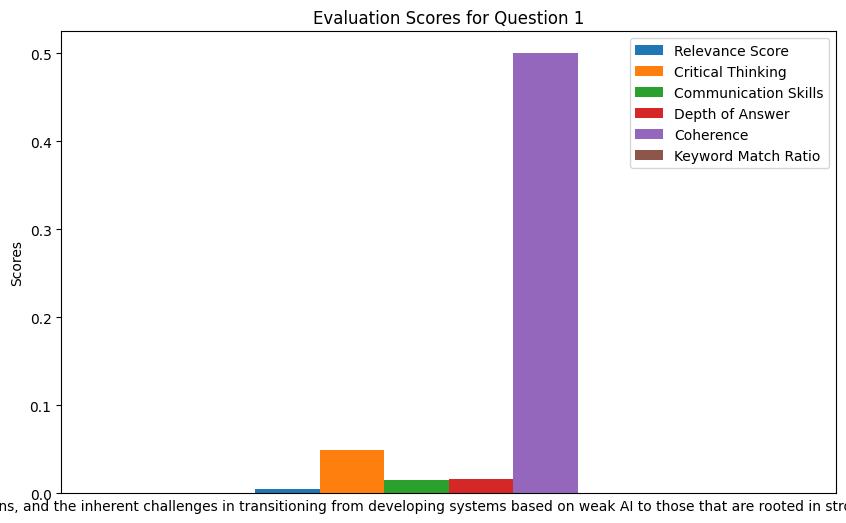

{'Overall Interview Score': 0.09762879248006091, 'Question-wise Scores': {'Relevance Score': [0.004895960832313341], 'Critical Thinking': [0.04895960832313341], 'Communication Skills': [0.015748031496062992], 'Depth of Answer': [0.01616915422885572], 'Coherence': [0.5], 'Keyword Match Ratio': [0.0]}, 'Overall Visual Representation': 'overall_evaluation_report.png', 'Detailed Results': [{'Question': 'As an AI engineer, you are undoubtedly aware of the concepts of weak AI and strong AI. Could you elaborate on their distinct characteristics, practical applications, and the inherent challenges in transitioning from developing systems based on weak AI to those that are rooted in strong AI? Could you also share your thoughts on the ethical implications and potential societal impacts that might arise from the widespread implementation of strong AI?', 'Transcribed Answer': ' 3. Corretugs', 'Reference Answer': "Weak AI, also referred to as Narrow AI, is designed to perform a specific task, such

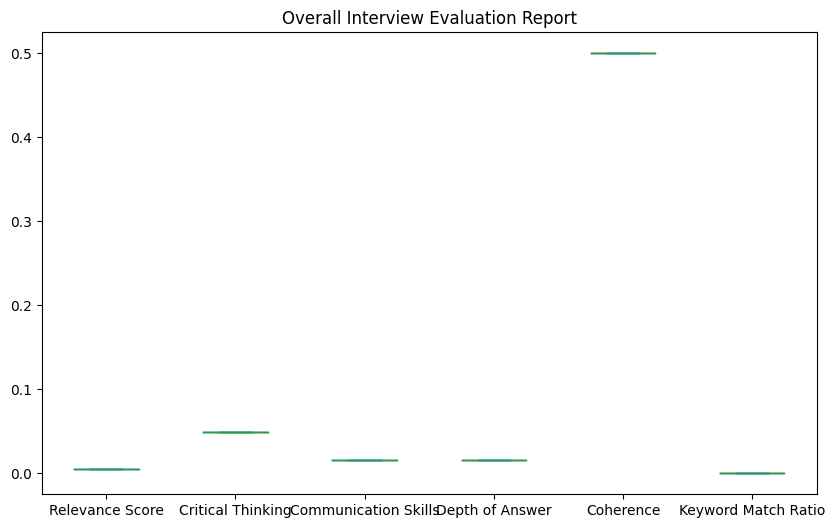

In [4]:
import os
import whisper
import openai
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sounddevice as sd
import scipy.io.wavfile as wav
from difflib import SequenceMatcher
from collections import defaultdict

# Set OpenAI API Key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
assert OPENAI_API_KEY, "Please set your OpenAI API Key in a .env file"
openai.api_key = OPENAI_API_KEY

# Ensure the directory containing ffmpeg is in the PATH environment variable
os.environ['PATH'] += os.pathsep + '/opt/homebrew/bin'

# Load Whisper Model for Transcribing Audio
whisper_model = whisper.load_model("base")

# Record audio in real-time
def record_audio(filename, duration=15, sample_rate=16000):
    print(f"Recording for {duration} seconds. Please answer the question...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()  # Wait until recording is finished
    wav.write(filename, sample_rate, recording)
    print(f"Recording completed and saved as {filename}.")

# Function to Transcribe Audio Files
def speech_to_text(audio_file):
    result = whisper_model.transcribe(audio_file)
    return result['text']

# Function to Generate GPT-4 Questions
def generate_question(topic):
    prompt = f"Generate a complex interview question for an AI engineer about {topic}."
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=100,
        temperature=0.6
    )
    return response['choices'][0]['message']['content']

# Function to Generate Reference Answers
def generate_reference_answer(question):
    prompt = f"Provide a comprehensive answer for the following AI engineering interview question: {question}"
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a knowledgeable assistant."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=150,
        temperature=0.6
    )
    return response['choices'][0]['message']['content']

# Function to Compare and Score Candidate Answers
def compare_answers(candidate_answer, reference_answer):
    matcher = SequenceMatcher(None, candidate_answer, reference_answer)
    similarity_score = matcher.ratio()
    return similarity_score

# Function to Categorize Answers
def categorize_response(candidate_response, reference_answer):
    important_keywords = extract_keywords(reference_answer)
    response_keywords = extract_keywords(candidate_response)
    keyword_match_ratio = len(set(response_keywords).intersection(important_keywords)) / len(important_keywords)
    category = "Accurate" if keyword_match_ratio > 0.7 else "General" if keyword_match_ratio > 0.4 else "Inaccurate"
    return category, keyword_match_ratio

# Keyword Extraction (Basic Example)
def extract_keywords(text):
    stop_words = set(["the", "is", "in", "and", "to", "with", "for", "on", "by", "an", "of", "a", "as"])
    keywords = [word for word in text.lower().split() if word not in stop_words]
    return set(keywords)

# Fine-tuned Evaluation Factors
def evaluate_candidate_response(candidate_response, reference_answer):
    relevance_score = compare_answers(candidate_response, reference_answer)
    critical_thinking_score = relevance_score * 10  # Enhanced calculation
    communication_score = min(len(candidate_response.split()) / len(reference_answer.split()), 1.0)  # Normalize to [0, 1]
    depth_of_answer_score = min(len(candidate_response) / len(reference_answer), 1.0)  # Normalize to [0, 1]
    coherence_score = 1 if candidate_response.count('.') >= reference_answer.count('.') else 0.5

    return {
        "Relevance Score": relevance_score,
        "Critical Thinking": critical_thinking_score,
        "Communication Skills": communication_score,
        "Depth of Answer": depth_of_answer_score,
        "Coherence": coherence_score
    }

# Conduct the Full Interview Process and Evaluation
def conduct_interview(topics, recording_duration=90):
    results = []
    report_data = defaultdict(list)

    for idx, topic in enumerate(topics):
        # Generate the question and display it
        question = generate_question(topic)
        print(f"Question {idx + 1}: {question}")

        # Record response
        audio_filename = f'recorded_response_{idx + 1}.wav'
        record_audio(audio_filename, duration=recording_duration)

        try:
            candidate_response = speech_to_text(audio_filename)
            reference_answer = generate_reference_answer(question)

            # Analyze Response
            category, keyword_match_ratio = categorize_response(candidate_response, reference_answer)
            scores = evaluate_candidate_response(candidate_response, reference_answer)
            scores["Category"] = category
            scores["Keyword Match Ratio"] = keyword_match_ratio
            results.append({
                "Question": question,
                "Transcribed Answer": candidate_response,
                "Reference Answer": reference_answer,
                "Scores": scores
            })

            # Add scores to report data
            for key, value in scores.items():
                report_data[key].append(value)

            # Generate visualization for each question
            generate_question_visualization(question, scores, idx + 1)

        except Exception as e:
            print(f"Failed to process {audio_filename}: {str(e)}")

    # Generate the Final Report
    final_report = generate_report(report_data, results)
    return final_report

# Generate Visualization for Each Question
def generate_question_visualization(question, scores, question_number):
    df = pd.DataFrame([scores])
    df.set_index(pd.Index([question_number]))

    # Plot bar chart for scores
    df.plot(kind='bar', figsize=(10, 6), legend=True)
    plt.title(f"Evaluation Scores for Question {question_number}")
    plt.xticks([])
    plt.xlabel(question)
    plt.ylabel('Scores')
    plt.legend(loc='upper right')
    plt.savefig(f"evaluation_question_{question_number}.png")
    plt.show()

# Generate Report and Visualization
def generate_report(report_data, results):
    df = pd.DataFrame(report_data)

    # Filter out non-numeric columns for calculating overall score
    numeric_cols = df.select_dtypes(include=[np.number])

    # Overall Interview Score
    if not numeric_cols.empty:
        overall_score = numeric_cols.mean().mean()
    else:
        overall_score = None

    # Visual Representation (e.g., Box Plot)
    numeric_cols.plot(kind='box', figsize=(10, 6))
    plt.title("Overall Interview Evaluation Report")
    plt.savefig("overall_evaluation_report.png")

    # Structure the final report
    final_report = {
        "Overall Interview Score": overall_score,
        "Question-wise Scores": numeric_cols.to_dict(orient='list'),
        "Overall Visual Representation": "overall_evaluation_report.png",
        "Detailed Results": results
    }

    return final_report

# Example Usage
topics = [
    "What is the difference between weak AI and strong AI?",
]

# Run the interview process
final_report = conduct_interview(topics, recording_duration=15)
print(final_report)
